Build logistic regression model and random forest model to predict whether a patient dies after admitted into ICU.

ICD9 diagnosis:
3961	Extracorporeal circulat
3891	Arterial catheterization	
3893	Venous cath NEC	
8856	Coronar arteriogr-2 cath	
9604	Insert endotracheal tube	
966	    Entral infus nutrit sub	
9671	Cont inv mec ven <96 hrs	
9672	Cont inv mec ven 96+ hrs	
9904	Packed cell transfusion	
9955	Vaccination NEC

Lab items:
ITEMID	LABEL               FLUID	  CATEGORY	
50820	pH	     	        Blood     Blood Gas	
50868	Anion Gap	        Blood	  Chemistry	
50882	Bicarbonate	        Blood	  Chemistry	
50902	Chloride	        Blood	  Chemistry	
50912	Creatinine	        Blood	  Chemistry	
50931	Glucose	            Blood	  Chemistry	
50960	Magnesium	        Blood	  Chemistry	
50970	Phosphate	        Blood	  Chemistry	
50971	Potassium	        Blood	  Chemistry	
50983	Sodium	            Blood	  Chemistry	
51006	Urea Nitrogen       Blood	  Chemistry	
51221	Hematocrit	        Blood	  Hematology	
51222	Hemoglobin	        Blood	  Hematology	
51248	MCH	                Blood	  Hematology	
51249	MCHC	            Blood	  Hematology	
51250	MCV	                Blood	  Hematology	
51265	Platelet Count	    Blood	  Hematology	
51277	RDW         	    Blood	  Hematology	
51279	Red Blood Cells	    Blood	  Hematology	
51301	White Blood Cells	Blood	  Hematology	

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  roc_auc_score, precision_score, recall_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import plot_partial_dependence
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from numpy import mean
from numpy import std
from pprint import pprint
import math

In [3]:
df = pd.read_csv('MIMIC_cleaned.csv')

In [4]:
age = df.AGE_ON_AD.astype(str).str.split(".", expand=True)[[0]]
age = age.astype(int)
np.sort(age[0][age[0] < 100].unique())
df["age"] = np.where(age[0] > 89, 90, age[0])

In [5]:
le = LabelEncoder()
df["gender"] = le.fit_transform(df.GENDER)

In [6]:
df["ethnicity"] = le.fit_transform(df.ETHNICITY)

### Missing data

In [7]:
#replece NA with 0
df.fillna(0, inplace=True)

### train and test data

In [8]:
y = df['HOSPITAL_EXPIRE_FLAG']

In [9]:
features_li = ['age', 'gender', 'ethnicity','ICU_STAY_DAYS', 'MULTI_ENTRY_ICU', 
               'ICD9_9955','ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672', 'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
               'PROP_ITEMID_51221', 'PROP_ITEMID_51222',
                'PROP_ITEMID_51248', 'PROP_ITEMID_51249', 'PROP_ITEMID_51250',
                'PROP_ITEMID_51265', 'PROP_ITEMID_51277', 'PROP_ITEMID_51279',
                'PROP_ITEMID_51301', 'PROP_ITEMID_50820', 'PROP_ITEMID_50868',
                'PROP_ITEMID_50882', 'PROP_ITEMID_50902', 'PROP_ITEMID_50912',
                'PROP_ITEMID_50931', 'PROP_ITEMID_50960', 'PROP_ITEMID_50970',
                'PROP_ITEMID_50971', 'PROP_ITEMID_50983', 'PROP_ITEMID_51006']
X = df[features_li]

In [10]:
X.columns

Index(['age', 'gender', 'ethnicity', 'ICU_STAY_DAYS', 'MULTI_ENTRY_ICU',
       'ICD9_9955', 'ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672',
       'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
       'PROP_ITEMID_51221', 'PROP_ITEMID_51222', 'PROP_ITEMID_51248',
       'PROP_ITEMID_51249', 'PROP_ITEMID_51250', 'PROP_ITEMID_51265',
       'PROP_ITEMID_51277', 'PROP_ITEMID_51279', 'PROP_ITEMID_51301',
       'PROP_ITEMID_50820', 'PROP_ITEMID_50868', 'PROP_ITEMID_50882',
       'PROP_ITEMID_50902', 'PROP_ITEMID_50912', 'PROP_ITEMID_50931',
       'PROP_ITEMID_50960', 'PROP_ITEMID_50970', 'PROP_ITEMID_50971',
       'PROP_ITEMID_50983', 'PROP_ITEMID_51006'],
      dtype='object')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
 test_size=0.2, random_state=0)

In [12]:
X_train.shape

(47180, 35)

In [13]:
X_test.shape

(11796, 35)

### sklearn Logistic regression

In [12]:
logisticRegr = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train)

In [13]:
predictions = logisticRegr.predict(X_test)

In [14]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.921414038657172


In [15]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)

Text(0.5, 225.76, 'Predicted label')

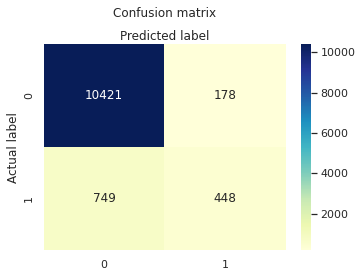

In [16]:
sns.set(rc={'figure.figsize':(5,3.5)})
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [47]:
print("Logistic auc score:", roc_auc_score(y_test, predictions))

Logistic auc score: 0.6787374843373174


In [46]:
print("Logistic Accuracy:", accuracy_score(y_test, predictions))
print("Logistic Precision:", precision_score(y_test, predictions))
print("Logistic Recall:", recall_score(y_test, predictions))
print(classification_report(y_test, predictions))

Logistic Accuracy: 0.921414038657172
Logistic Precision: 0.7156549520766773
Logistic Recall: 0.3742690058479532
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     10599
           1       0.72      0.37      0.49      1197

    accuracy                           0.92     11796
   macro avg       0.82      0.68      0.72     11796
weighted avg       0.91      0.92      0.91     11796



In [45]:
#Get feature importance by coefficient
zip_iterator = zip(X_train.columns, logisticRegr.coef_[0])
coef_logit = dict(zip_iterator) 
sort_coef = sorted(coef_logit.items(), key=lambda x: x[1], reverse=True)
for i in sort_coef:
    print(i[0], i[1])

PROP_ITEMID_50868 1.8645790883647906
ICD9_9672 1.4511753097322155
PROP_ITEMID_51301 1.4475841463494903
PROP_ITEMID_50983 1.3377124530489855
ICD9_9671 1.1818503651620078
PROP_ITEMID_50971 1.0184823548913697
PROP_ITEMID_50931 0.8877412932208923
PROP_ITEMID_50820 0.8767619107646165
PROP_ITEMID_50882 0.7954872886149137
PROP_ITEMID_51265 0.7894341574004886
PROP_ITEMID_50960 0.5786971859117579
PROP_ITEMID_51277 0.43512413457315696
PROP_ITEMID_51006 0.3456510193749629
ICD9_3891 0.2896410660891787
PROP_ITEMID_50912 0.2502789746676442
PROP_ITEMID_50970 0.24960537101485
ICD9_9604 0.1711645801657197
PROP_ITEMID_50902 0.1656892891886428
gender 0.1342352743918911
PROP_ITEMID_51249 0.12978116454334035
PROP_ITEMID_51250 0.12616722963521448
PROP_ITEMID_51248 0.09856121614296526
PROP_ITEMID_51279 0.06923409328689456
age 0.03179557160589237
ICD9_9904 0.03097310127680012
ethnicity 0.0161527292746418
ICU_STAY_DAYS -0.009038124972159499
ICD9_3893 -0.05776181388285242
ICD9_8856 -0.12221807164259228
MULTI_EN

### Stat model  logistic regression

In [14]:
#import statsmodels.discrete.discrete_model as sm
import statsmodels.api as sm

In [71]:
X_train = np.array(X_train, dtype=float)
X_test = np.array(X_test, dtype=float)

In [16]:
y_train = np.array(y_train, dtype=float)

In [17]:
logit = sm.Logit(y_train, X_train, solver='lbfgs').fit()

Optimization terminated successfully.
         Current function value: 0.250280
         Iterations 12


In [18]:
#To get -log(p values)
values = list()
for i in range(35):
    value = (-1)*math.log(logit.pvalues[i])
    values.append(value)

In [48]:
p_value = list(logit.pvalues)

In [62]:
coef = list(logit.params)

In [64]:
#To get OR
OR = list()
for i in range(35):
    exp = math.exp(logit.params[i])
    OR.append(exp)

In [20]:
features = ['age', 'gender', 'ethnicity', 'ICU_STAY_DAYS', 'MULTI_ENTRY_ICU',
       'ICD9_9955', 'ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672',
       'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
       'PROP_ITEMID_51221', 'PROP_ITEMID_51222', 'PROP_ITEMID_51248',
       'PROP_ITEMID_51249', 'PROP_ITEMID_51250', 'PROP_ITEMID_51265',
       'PROP_ITEMID_51277', 'PROP_ITEMID_51279', 'PROP_ITEMID_51301',
       'PROP_ITEMID_50820', 'PROP_ITEMID_50868', 'PROP_ITEMID_50882',
       'PROP_ITEMID_50902', 'PROP_ITEMID_50912', 'PROP_ITEMID_50931',
       'PROP_ITEMID_50960', 'PROP_ITEMID_50970', 'PROP_ITEMID_50971',
       'PROP_ITEMID_50983', 'PROP_ITEMID_51006']

In [21]:
logit.summary(xname=features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                47180
Model:                          Logit   Df Residuals:                    47145
Method:                           MLE   Df Model:                           34
Date:                Wed, 24 Nov 2021   Pseudo R-squ.:                  0.2233
Time:                        06:03:38   Log-Likelihood:                -11808.
converged:                       True   LL-Null:                       -15203.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.0015      0.001     -1.693      0.090      -0.003       0.000
gender               -0.3030      0.035     -8.760      0.000      -0.371      -0.235
ethnicity            -0.0526      0.001    -37.020      0.000      -0.055      -0.050
ICU_STAY_DAYS        -0.0330      0.003    -12.024      0.000      -0.038      -0.028
MULTI_ENTRY_ICU      -0.4389      0.044    -10.028      0.000      -0.525      -0.353
ICD9_9955            -6.1602      0.710     -8.680      0.000      -7.551      -4.769
ICD9_3893            -0.0314      0.033     -0.960      0.337      -0.096       0.033
ICD9_9604             0.0792      0.049      1.610      0.107      -0.017       0.176
ICD9_966             -0.2444      0.051     -4.780      0.000      -0.345      -0.144
ICD9_9672             1.6592      0.066     25.320      0.000       1.531       1.788
ICD9_9904             0.0831      0.050      1.670      0.095      -0.014       0.181
ICD9_9671             1.0128      0.052     19.437      0.000       0.911       1.115
ICD9_3961            -1.2520      0.102    -12.333      0.000      -1.451      -1.053
ICD9_8856            -0.1380      0.069     -1.989      0.047      -0.274      -0.002
ICD9_3891             0.3440      0.049      7.025      0.000       0.248       0.440
PROP_ITEMID_51221    -0.6713      0.115     -5.828      0.000      -0.897      -0.446
PROP_ITEMID_51222    -0.9473      0.107     -8.860      0.000      -1.157      -0.738
PROP_ITEMID_51248    -0.2517      0.060     -4.200      0.000      -0.369      -0.134
PROP_ITEMID_51249    -0.4173      0.063     -6.649      0.000      -0.540      -0.294
PROP_ITEMID_51250    -0.2573      0.070     -3.663      0.000      -0.395      -0.120
PROP_ITEMID_51265     0.7674      0.050     15.478      0.000       0.670       0.865
PROP_ITEMID_51277     0.1819      0.045      4.043      0.000       0.094       0.270
PROP_ITEMID_51279    -0.7037      0.091     -7.766      0.000      -0.881      -0.526
PROP_ITEMID_51301     0.9536      0.049     19.513      0.000       0.858       1.049
PROP_ITEMID_50820     0.6368      0.049     12.916      0.000       0.540       0.733
PROP_ITEMID_50868     1.6488      0.101     16.273      0.000       1.450       1.847
PROP_ITEMID_50882     0.4671      0.059      7.889      0.000       0.351       0.583
PROP_ITEMID_50902    -0.1907      0.064     -2.993      0.003      -0.316      -0.066
PROP_ITEMID_50912     0.2680      0.057      4.696      0.000       0.156       0.380
PROP_ITEMID_50931    -0.2988      0.062     -4.802      0.000      -0.421      -0.177
PROP_ITEMID_50960     0.3002      0.093      3.233      0.001       0.118       0.482
PROP_ITEMID_50970    -0.0653      0.062     -1.054      0.292      -0.187       0.056
PROP_ITEMID_50971     0.1124      0.097      1.164      0.244      -0.077       0.302
PROP_ITEMID_50983     1.4826      0.076     19.561      0.000       1.334       1.631
PROP_ITEMID_51006     0.8922      0.062     14.364      0.0

In [66]:
data_tuples = list(zip(features, coef, OR, p_value, values))
est = pd.DataFrame(data_tuples, columns=['features','coef', 'OR','p_value','-log(p_value)'])

In [69]:
est.sort_values(by=['OR'], ascending=False)

,features,coef,OR,p_value,-log(p_value)
9,ICD9_9672,1.659162,5.254905,1.935743e-141,324.004007
25,PROP_ITEMID_50868,1.648826,5.200871,1.522623e-59,135.432086
33,PROP_ITEMID_50983,1.482553,4.404175,3.334329e-85,194.515461
11,ICD9_9671,1.012778,2.753240,3.721535e-84,192.103011
23,PROP_ITEMID_51301,0.953615,2.595075,8.566025e-85,193.571929
34,PROP_ITEMID_51006,0.892219,2.440540,8.720228e-47,106.055854
20,PROP_ITEMID_51265,0.767410,2.154180,4.907224e-54,122.748887
24,PROP_ITEMID_50820,0.636820,1.890460,3.673814e-38,86.197003
26,PROP_ITEMID_50882,0.467059,1.595296,3.055425e-15,33.421858
14,ICD9_3891,0.344044,1.410641,2.136329e-12,26.871932


In [76]:
sm_pred = logit.predict(X_test)
sm_pred

array([7.03479798e-03, 1.27948433e-04, 5.26562291e-01, ...,
       8.47812624e-03, 2.56786063e-01, 1.14949410e-03])

In [83]:
cnf_matrix = metrics.confusion_matrix(y_test,  sm_pred.round())
cnf_matrix

array([[10354,   245],
       [  884,   313]])

Text(0.5, 225.76, 'Predicted label')

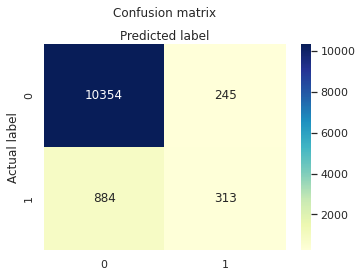

In [82]:
sns.set(rc={'figure.figsize':(5,3.5)})
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [84]:
print("Statmodel Logistic auc score:", roc_auc_score(y_test, sm_pred.round()))

Statmodel Logistic auc score: 0.6191858313582805


In [85]:
print("Statmodel Logistic Accuracy:", accuracy_score(y_test, sm_pred.round()))
print("Statmodel Logistic Precision:", precision_score(y_test, sm_pred.round()))
print("Statmodel Logistic Recall:", recall_score(y_test, sm_pred.round()))
print(classification_report(y_test, sm_pred.round()))

Statmodel Logistic Accuracy: 0.9042895896914208
Statmodel Logistic Precision: 0.5609318996415771
Statmodel Logistic Recall: 0.26148705096073516
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10599
           1       0.56      0.26      0.36      1197

    accuracy                           0.90     11796
   macro avg       0.74      0.62      0.65     11796
weighted avg       0.88      0.90      0.89     11796



### Random forest hyperparameter tuning

In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 600, stop = 1000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(100,500, num = 3)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True]
class_weight = ["balanced", "balanced_subsample"]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'class_weight': class_weight}
pprint(random_grid)

{'class_weight': ['balanced', 'balanced_subsample'],
 'max_depth': [100, 300, 500, None],
 'n_estimators': [600, 800, 1000]}


In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
random.seed(2021)
randomforest = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = randomforest,
                               param_distributions = random_grid, 
                               n_iter = 1000, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1, scoring='roc_auc').fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 24 is smaller than n_iter=1000. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 14.2min finished


In [23]:
rf_random.best_params_

{'n_estimators': 1000, 'max_depth': 300, 'class_weight': 'balanced'}

In [24]:
y_pred = rf_random.best_estimator_.predict(X_test)

In [25]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

Text(0.5, 225.76, 'Predicted label')

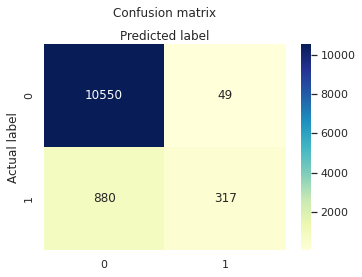

In [26]:
sns.set(rc={'figure.figsize':(5,3.5)})
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [42]:
print("Random forest auc score:", roc_auc_score(y_test, y_pred))

Random forest auc score: 0.6301028304320572


In [39]:
print("Random forest Accuracy:", accuracy_score(y_test, y_pred))
print("Random forest Precision:", precision_score(y_test, y_pred))
print("Random forest Recall:", recall_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Random forest Accuracy: 0.921244489657511
Random forest Precision: 0.8661202185792349
Random forest Recall: 0.264828738512949
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10599
           1       0.87      0.26      0.41      1197

    accuracy                           0.92     11796
   macro avg       0.89      0.63      0.68     11796
weighted avg       0.92      0.92      0.90     11796



In [29]:
feature_imp = pd.Series(rf_random.best_estimator_.feature_importances_,index=X.columns).sort_values(ascending=False)

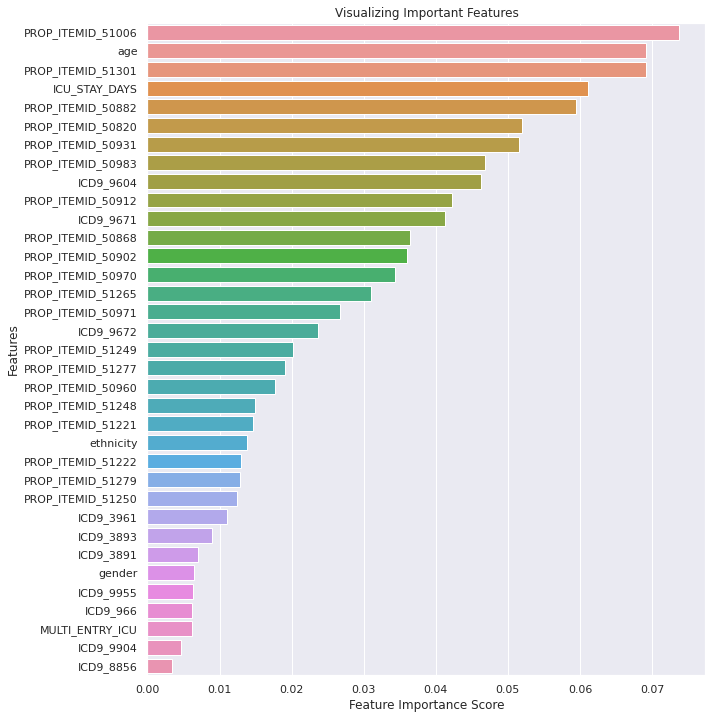

In [30]:
sns.set(rc={'figure.figsize':(10,12)})
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()